<a href="https://colab.research.google.com/github/HubertasVin/deep-learning-practice/blob/main/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importuojamos reikalingos bibliotekos

In [42]:
!pip install pyngrok
!pip install tabulate


import os
import numpy as np
import torch
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from google.colab import drive
drive.mount('/content/drive')

# Metrics
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

# API imports
from flask import Flask, request, jsonify
from pyngrok import ngrok
import requests
from io import BytesIO

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

DATA_DIR = '/content/drive/MyDrive/colab_content'
OI_DATA_DIR = os.path.join(DATA_DIR, "OpenImages")
MODEL_SAVE_PATH = os.path.join(DATA_DIR, "keras_vgg_model.keras")
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 60
LEARNING_RATE = 1e-4
TRAIN_MODE = True
NGROK_AUTH_TOKEN = "2v8l4mW8zOFneFzX7p47qORuEwS_4EcRU64N6iq1mUNEpXN3G"
API_ENABLE = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda:0


Duomenų įkėlimas ir paruošimas

In [43]:
def get_image_paths_and_labels(root_dir):
    classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    image_paths = []
    labels = []
    for cls in classes:
        images_dir = os.path.join(root_dir, cls, "images")
        if os.path.isdir(images_dir):
            for file in os.listdir(images_dir):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(images_dir, file))
                    labels.append(class_to_idx[cls])
        else:
            print(f"Warning: {images_dir} not found.")
    return image_paths, labels, classes, class_to_idx

def load_and_preprocess_image(path, label, training=True):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    if training:
        img = tf.image.random_flip_left_right(img)
    return img, label

def create_datasets():
    image_paths, labels, classes, class_to_idx = get_image_paths_and_labels(OI_DATA_DIR)
    print("Total images:", len(image_paths))
    print("Classes found:", classes)
    indices = np.arange(len(image_paths))
    np.random.shuffle(indices)
    split = int(0.8 * len(image_paths))
    train_idx, val_idx = indices[:split], indices[split:]
    train_paths = [image_paths[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    val_paths   = [image_paths[i] for i in val_idx]
    val_labels  = [labels[i] for i in val_idx]

    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    train_ds = train_ds.map(lambda p, l: load_and_preprocess_image(p, l, training=True),
                              num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    val_ds = val_ds.map(lambda p, l: load_and_preprocess_image(p, l, training=False),
                        num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds, classes, class_to_idx

In [44]:
def build_custom_vgg(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1: Two Conv layers (64 filters)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2: Two Conv layers (128 filters)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3: Three Conv layers (256 filters)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4: Three Conv layers (512 filters)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5: Three Conv layers (512 filters)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Classification head
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    return model

Modelio kompiliavimas ir treniravimas

In [45]:
def train_model():
    if TRAIN_MODE:
        train_ds, val_ds, classes, class_to_idx = create_datasets()
        num_classes = len(classes)
        input_shape = IMG_SIZE + (3,)

        model = build_custom_vgg(input_shape, num_classes)
        model.summary()

        model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),  # stops training if no improvement in val_loss for 5 epochs
            ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True)   # saves the best model based on val_loss
        ]

        history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks)
        model.save(MODEL_SAVE_PATH)
    else:
        print("Loading existing model...")
        model = keras.models.load_model(MODEL_SAVE_PATH)

    return model, history, classes, class_to_idx, val_ds

Metrikos

Total images: 1061
Classes found: ['sandal', 'strawberry', 'traffic light']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      33,558,528 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 65,066,819 (248.21 MB)

 Trainable params: 65,066,819 (248.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 49s 675ms/step - accuracy: 0.3741 - loss: 1.0612 - val_accuracy: 0.5915 - val_loss: 0.8912
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 692ms/step - accuracy: 0.6597 - loss: 0.8774 - val_accuracy: 0.6197 - val_loss: 0.8161
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 536ms/step - accuracy: 0.6333 - loss: 0.7570 - val_accuracy: 0.6291 - val_loss: 0.7037
Epoch 4/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 581ms/step - accuracy: 0.6609 - loss: 0.6909 - val_accuracy: 0.6338 - val_loss: 0.6926
Epoch 5/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 764ms/step - accuracy: 0.6758 - loss: 0.6616 - val_accuracy: 0.6479 - val_loss: 0.6855
Epoch 6/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 574ms/step - accuracy: 0.6812 - loss: 0.6869 - val_accuracy: 0.6714 - val_loss: 0.6780
Epoch 7/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 282ms/step - accuracy: 0.7156 - loss: 0.6283 - val_accuracy: 0.6573 - val_loss: 0.6835
Epoch 8/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - accuracy: 0.6839 - loss: 0.6430 - val_accu

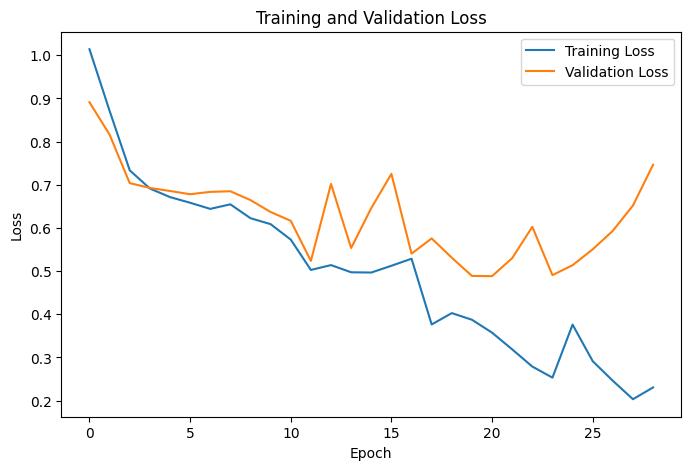

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step

Validation Metrics:
Accuracy: 0.8075117370892019
Precision: 0.8156321389005163
Recall: 0.8075117370892019
F1 Score: 0.8103326616943285

Confusion Matrix:
+---------------+----------+--------------+-----------------+
|               |   sandal |   strawberry |   traffic light |
+===============+==========+==============+=================+
| sandal        |       49 |           10 |               6 |
+---------------+----------+--------------+-----------------+
| strawberry    |       14 |           63 |               0 |
+---------------+----------+--------------+-----------------+
| traffic light |       10 |            1 |              60 |
+---------------+----------+--------------+-----------------+


In [46]:
if TRAIN_MODE:
    model, history, classes, class_to_idx, val_ds = train_model()
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
else:
    _, val_ds, classes, class_to_idx = create_datasets()
    model = keras.models.load_model(MODEL_SAVE_PATH)

y_true = []
y_pred = []
for images, labels in val_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("\nValidation Metrics:")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)

headers = [""] + classes
table = []
for i, row in enumerate(cm):
    table.append([classes[i]] + list(row))
print("\nConfusion Matrix:")
print(tabulate(table, headers=headers, tablefmt="grid"))

API skirtas įvesti nuotraukas rankiniu būdu.

Nuotraukos testavimui su API:
- https://img.freepik.com/free-photo/yummy-strawberries-red-mellow-ripe-with-green-leafs-dark-desk_179666-391.jpg
- https://img.freepik.com/free-photo/strawberry-isolated-white-background_1232-1974.jpg
- https://img.freepik.com/free-photo/traffic-light-city-streets_23-2149091964.jpg
- https://img.freepik.com/free-photo/green-traffic-light-intersection_53876-153444.jpg
- https://img.freepik.com/premium-photo/close-up-yellow-street-traffic-light-hanging-from-pole_1048944-23361333.jpg
- https://img.freepik.com/free-photo/summer-slipper-white-shoes-sandals_1203-6528.jpg
- https://img.freepik.com/premium-photo/close-up-shoes-sand_1048944-30578092.jpg
- https://img.freepik.com/free-vector/man-brown-casual-flip-flop-sandal-shoes-vector_53876-25895.jpg

In [47]:
def predict_image(image):
    image = image.resize(IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = tf.cast(img_array, tf.float32) / 255.0
    preds = model.predict(img_array)
    pred_class_idx = np.argmax(preds, axis=1)[0]
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    return idx_to_class.get(pred_class_idx, "Unknown")


In [48]:
app = Flask(__name__)

@app.route('/test', methods=['GET'])
def test_endpoint():
    return jsonify({"message": "Test endpoint working!"}), 200

@app.route('/predict', methods=['POST'])
def predict():
    if "file" in request.files:
        file = request.files["file"]
        try:
            image = tf.keras.preprocessing.image.load_img(file, target_size=IMG_SIZE)
        except Exception as e:
            return jsonify({"error": "Invalid image file."}), 400
    else:
        data = request.get_json(force=True)
        if "url" in data:
            response = requests.get(data["url"])
            image = tf.keras.preprocessing.image.load_img(BytesIO(response.content), target_size=IMG_SIZE)
        elif "file_path" in data:
            image = tf.keras.preprocessing.image.load_img(data["file_path"], target_size=IMG_SIZE)
        else:
            return jsonify({"error": "Provide 'url', 'file_path', or upload a file as 'file'."}), 400

    prediction = predict_image(image)
    return jsonify({"prediction": prediction})

if __name__ == '__main__':
    import sys
    # Start API server
    if API_ENABLE:
        ngrok.set_auth_token(NGROK_AUTH_TOKEN)
        public_url = ngrok.connect(5000)
        print("Public URL:", public_url)
        app.run(host='0.0.0.0', port=5000)

Public URL: NgrokTunnel: "https://3889-34-16-237-61.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


In [49]:
tf.keras.backend.clear_session()